In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.2 MB/s eta 0:00:00


In [2]:
pip install "gymnasium[box2d]"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 10.8 MB/s eta 0:00:0000:0100:01
done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-linux_x86_64.whl size=2836677 sha256=6cc7c75d2c687bba6e0fb5382b73aa7089d0246eef2f6a0cc067f4e40e81de79
  Stored in directory: /root/.cache/pip/wheels/8b/95/16/1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py
Note: you may need to restart the kernel to use updated packages.


In [61]:
%matplotlib inline

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

import seaborn as sns

import tensorflow as tf
import torch
from typing import Tuple

from tqdm import tqdm

In [63]:
import gymnasium as gym

In [70]:
from IPython.display import clear_output
import time

In [31]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

for _ in range(2):
    observation, info = env.reset()
    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
    
        episode_over = terminated or truncated

env.close()

In [66]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate:float,
        initial_epsilon:float,
        epsilon_decay:float,
        final_epsilon:float,
        discount_factor:float=0.95
    ):
        """
        Initialize a RL agent with empty dictionary of state-action value (q_values), a learning
        rate and an epsilon

        dicount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda:np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(
        self,
        obs: Tuple[int, int, bool]
    )->int:
        """
        Return the best action with proba (1 - epsilon) otherwise a random 
        action with proba epsilon to ensure exploration
        """

        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: Tuple[int, int, bool],
        action:int,
        reward:float,
        terminated:bool,
        next_obs: Tuple[int, int, bool]
    ):
        """
        Updates the Q-value of an action
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon, self.epsilon_decay)

Q-value function is used to estimate the optimal action to take in each state. The optimal action in a state is the one that maximazed the long-term reward.

In [67]:
# hyperparams
learning_rate = 0.01
n_episodes = 10
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2) # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

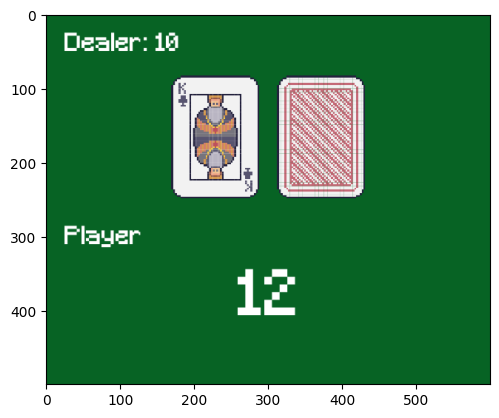

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


In [71]:
env = gym.make('Blackjack-v1', render_mode='rgb_array', sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    episode_finish = False
    clear_output()

    # one episode
    while not episode_finish:
        observation, info = env.reset()
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        plt.imshow(frame)
        plt.show()

        episode_finish = terminated or truncated
        obs = next_obs
        time.sleep(1)

    agent.decay_epsilon()